In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

df = pd.read_parquet('../data/processed/preprocessed_data_with_embeddings_and_ohe.parquet')

# The model a "Neural Collaborative Filtering" (NCF) model. 
# It is designed for collaborative filtering tasks,  where it leverages neural networks to learn user and item embeddings and combines them to predict user-item ratings

In [42]:
# Prepare feature matrix X and target vector y
X = df.drop(columns=['rating'])
y = df['rating']

# Create mappings for userId and movieId to continuous indices
unique_users = X['userId'].unique()
unique_movies = X['movieId'].unique()

# Create dictionaries to map user_id and movie_id to continuous indices.
user_mapping = {user_id: idx for idx, user_id in enumerate(unique_users)}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(unique_movies)}

# Map userId and movieId to continuous indices to get: efficient computation, memory efficiency, compatibility
X['userId'] = X['userId'].map(user_mapping)
X['movieId'] = X['movieId'].map(movie_mapping)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Get the number of unique users and items
num_users = len(user_mapping)
num_items = len(movie_mapping)

In [43]:
# Define the NCF model


embedding_dim = 20
regularization = l2(0.001)

# User and item inputs
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# User and item embeddings
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding', embeddings_regularizer=regularization)(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, name='item_embedding', embeddings_regularizer=regularization)(item_input)

# Flatten embeddings
user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

# Additional features input
additional_features_input = Input(shape=(X_train.shape[1] - 2,), name='additional_features_input')

# Concatenate user, item embeddings with additional features
concat = Concatenate()([user_flat, item_flat, additional_features_input])

# Fully connected layers
fc1 = Dense(64, activation='relu')(concat)
drop1 = Dropout(0.2)(fc1)
fc2 = Dense(32, activation='relu')(drop1)
drop2 = Dropout(0.2)(fc2)
fc3 = Dense(16, activation='relu')(drop2)
output = Dense(1)(fc3)

# Compile the model
model = Model(inputs=[user_input, item_input, additional_features_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Prepare the inputs for training and testing
train_user_input = X_train['userId']
train_item_input = X_train['movieId']
train_additional_features = X_train.drop(columns=['userId', 'movieId'])

test_user_input = X_test['userId']
test_item_input = X_test['movieId']
test_additional_features = X_test.drop(columns=['userId', 'movieId'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)


In [44]:
# Ensure all elements in train_additional_features and test_additional_features are numeric
train_additional_features = train_additional_features.apply(pd.to_numeric, errors='coerce').fillna(0)
test_additional_features = test_additional_features.apply(pd.to_numeric, errors='coerce').fillna(0)

# Convert inputs to numpy arrays and ensure they are the correct type
train_user_input = np.array(train_user_input)
train_item_input = np.array(train_item_input)
train_additional_features = np.asarray(train_additional_features, dtype=np.float32)

test_user_input = np.array(test_user_input)
test_item_input = np.array(test_item_input)
test_additional_features = np.asarray(test_additional_features, dtype=np.float32)


In [45]:
# Train the model
history = model.fit([train_user_input, train_item_input, train_additional_features], y_train,
                    epochs=35, batch_size=256, validation_split=0.1, verbose=1, callbacks=[reduce_lr])

# Evaluate the model
y_pred = model.predict([test_user_input, test_item_input, test_additional_features])
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:.4f}')

Epoch 1/35
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 1061s 76ms/step - loss: 0.8872 - val_loss: 0.7724 - learning_rate: 0.0010
Epoch 2/35
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 473s 34ms/step - loss: 0.7664 - val_loss: 0.7671 - learning_rate: 0.0010
Epoch 3/35
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 480s 35ms/step - loss: 0.7660 - val_loss: 0.7683 - learning_rate: 0.0010
Epoch 4/35
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 487s 35ms/step - loss: 0.7679 - val_loss: 0.7723 - learning_rate: 0.0010
Epoch 5/35
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 498s 36ms/step - loss: 0.7686 - val_loss: 0.7702 - learning_rate: 0.0010
Epoch 6/35
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 501s 36ms/step - loss: 0.7339 - val_loss: 0.7117 - learning_rate: 2.0000e-04
Epoch 7/35
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 507s 36ms/step - loss: 0.7033 - val_loss: 0.7053 - learning_rate: 2.0000e-04
Epoch 8/35
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 510s 37ms/step - loss: 0.6984 - val_loss: 0.7047 - learning_rate: 2.0000e-04
Epoch 9/35
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 510s 37

c:\Users\Leo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [46]:
from keras.models import load_model

# Save the model
model.save('../models/ncf_model.keras')

# Later, to load the model
#loaded_model = load_model('../models/ncf_model.keras')


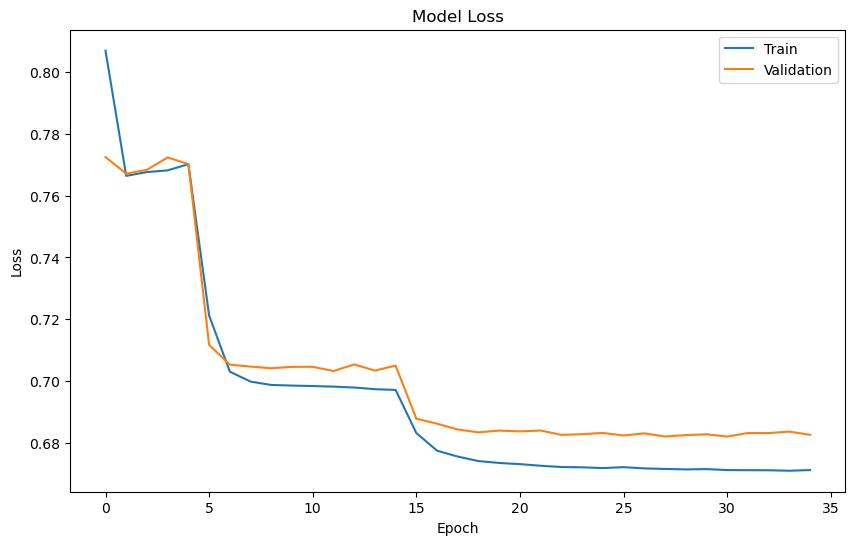

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, precision_score

# Evaluate the model
y_pred = model.predict([test_user_input, test_item_input, test_additional_features])  # Ensure all necessary inputs are included

# Convert predictions to binary by setting a threshold (e.g., 3.5)
threshold = 3.5
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = (y_pred >= threshold).astype(int)

# Calculate regression metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate classification metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary, average='weighted')
precision = precision_score(y_test_binary, y_pred_binary, average='weighted')

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R^2 Score', 'Accuracy', 'F1 Score', 'Precision'],
    'Value': [rmse, mae, r2, accuracy, f1, precision]
})

# Print the metrics table
print(metrics_df)


41185/41185 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step


c:\Users\Leo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


      Metric     Value
0       RMSE  0.916193
1        MAE  0.668121
2  R^2 Score  0.249620
3   Accuracy  0.693522
4   F1 Score  0.696312
5  Precision  0.705251


In [49]:
import joblib

joblib.dump(metrics_df, "../models/Metrics_NCF_DL.pkl")

['../models/Metrics_NCF_DL.pkl']

In [50]:
joblib.load("../models/Metrics_NCF_DL.pkl")

,Metric,Value
0,RMSE,0.916193
1,MAE,0.668121
2,R^2 Score,0.249620
3,Accuracy,0.693522
4,F1 Score,0.696312
5,Precision,0.705251


In [51]:
# double check, if all features were used

# Print the columns of the DataFrame
print("Columns in DataFrame:")
print(df.columns)

# Check the shape of the training data
print("\nShape of training data:")
print(X_train.shape)
print("Columns in X_train:")
print(X_train.columns)

# Verify the inputs being fed to the model
print("\nSample inputs to the model:")
print("User input sample:", train_user_input[:5])  # Convert to list for printing
print("Item input sample:", train_item_input[:5])  # Convert to list for printing
print("Additional features input sample:\n", pd.DataFrame(train_additional_features).head())

# Verify the number of additional features
print("\nNumber of additional features (excluding userId and movieId):")
print(train_additional_features.shape[1])

# Ensure the inputs match the expected shapes
print("\nModel Input Shapes:")
print(f"User input shape: {train_user_input.shape}")
print(f"Item input shape: {train_item_input.shape}")
print(f"Additional features input shape: {train_additional_features.shape}")


Columns in DataFrame:
Index(['movieId', 'userId', 'rating', 'tag_embedding', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

Shape of training data:
(3953730, 22)
Columns in X_train:
Index(['movieId', 'userId', 'tag_embedding', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

Sample inputs to the model:
User input sample: [ 85096 145305  39073   5049  65081]
Item input sample: [ 417 2146  662 2079 1749]
Additional features input sample:
     0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  